# Explore perturbation clusters

A common question we aim to ask is “What other perturbations look like
mine?” The easiest way to get the answer for this question is using our
[browsable
datasets](https://github.com/broadinstitute/monorepo/tree/main/libs/jump_rr#quick-data-access).
In this case we would like to use the ‘Matches’ databases, which provide
cosines similarities between perturbations within a dataset, obtained
from all-vs-all calculations.

The limitation of this approach is that the size of JUMP results in two
challenges: - Calculating the distances across all pairs of
perturbations is intractable for most computers without a GPU (Graphics
Processing Unit). - The resultant similarity matrix is too big for web
browser-based exploration, so we limit the browsable similarity dataset
to the top 100 most correlated/anticorrelated pairs of perturbations.

Despite the aforementioned problems, we provide the full matrix of
perturbation distances in case it is of use to data analysts. You can
find this and other datasets on
[Zenodo](https://zenodo.org/records/13259495/latest). The data files of
interest for this exercise are “{org,crispr}\_cosinesim_full.parquet”.

The following analysis focuses on showcasing how to query one of these
distance matrices to find all the distances between any given
perturbation and all others. One use-case of this is testing how similar
perturbation A and B are relative to perturbation C’s similarity to A.

------------------------------------------------------------------------

In [1]:
import requests
from random import choices, seed

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

We select the CRISPR dataset for this example. As with previous
examples, this is a lazy-loaded data frame. This enables us to download
very big datasets without worrying about whether or not they will fill
into memory. In these datasets, the values range between 0 and 2, where
0 means that two profiles are the same, 1 means that they are orthogonal
(completely uncorrelated) and 2 means that they are completely
anticorrelated.

In [2]:
latest_id = requests.get(
    "https://zenodo.org/api/records/15029005/versions/latest"
).json()["id"]
distances = pl.scan_parquet(
    f"https://zenodo.org/api/records/{latest_id}/files/crispr_cosinesim_full.parquet/content"
)
distances.head().collect()

Note that the only metadata information in this matrix are the column
names as JUMP IDs (JCP2022_X), meaning that we will need to use a mapper
from these JUMP ids to conventional names; feel free to look at the
previous how-to that demonstrates that. We will now select three
features at random and look at their correlation matrix

In [3]:
seed(42)
cols = distances.collect_schema().names()
ncols = len(cols)
sampled_col_idx = sorted(choices(range(ncols), k=3))
sampled_cols = [cols[ix] for ix in sampled_col_idx]

sampled_distances = (
    distances.with_row_index()
    .filter(pl.col("index").is_in(sampled_col_idx))
    .select(pl.col(sampled_cols))
    .collect()
)
sampled_distances

Finally, we plot them in a heatmap for easier visualisation

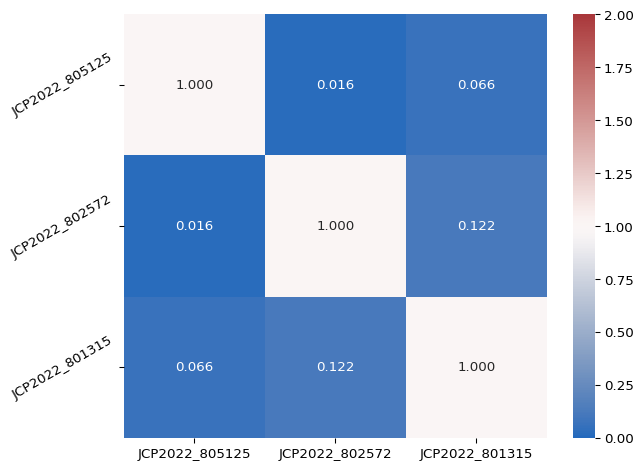

In [4]:
pandas_correlation = sampled_distances.to_pandas()
pandas_correlation.index = pandas_correlation.columns
sns.heatmap(
    pandas_correlation,
    annot=True,
    fmt=".3f",
    vmin=0,
    vmax=2,
    cmap=sns.color_palette("vlag", as_cmap=True),
)
plt.yticks(rotation=30)
plt.tight_layout()

Whilst in this case it is not a terribly interesting result, this shows
that we see no correlation between three randomly selected
perturbations.